In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm torch torchvision matplotlib seaborn

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

data_path = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images_converted'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(root=data_path, transform=transform)
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [4]:
import timm
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_senet = timm.create_model('senet154', pretrained=True)
model_senet.fc = nn.Linear(model_senet.fc.in_features, len(dataset.classes))
model_senet = model_senet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_senet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/461M [00:00<?, ?B/s]

In [5]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
epochs = 25

for epoch in range(epochs):
    model_senet.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_senet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model_senet.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_senet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(valid_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/25, Train Loss: 1.2998, Train Acc: 63.06%, Val Loss: 4.1082, Val Acc: 59.05%
Epoch 2/25, Train Loss: 0.5773, Train Acc: 82.99%, Val Loss: 0.6060, Val Acc: 84.13%
Epoch 3/25, Train Loss: 0.2498, Train Acc: 92.86%, Val Loss: 0.3425, Val Acc: 91.11%
Epoch 4/25, Train Loss: 0.2203, Train Acc: 93.74%, Val Loss: 0.1778, Val Acc: 94.60%
Epoch 5/25, Train Loss: 0.1492, Train Acc: 95.58%, Val Loss: 0.4010, Val Acc: 87.62%
Epoch 6/25, Train Loss: 0.0637, Train Acc: 98.16%, Val Loss: 0.0874, Val Acc: 97.78%
Epoch 7/25, Train Loss: 0.0141, Train Acc: 99.66%, Val Loss: 0.0722, Val Acc: 97.46%
Epoch 8/25, Train Loss: 0.0172, Train Acc: 99.80%, Val Loss: 0.1052, Val Acc: 96.19%
Epoch 9/25, Train Loss: 0.0173, Train Acc: 99.52%, Val Loss: 0.0317, Val Acc: 98.41%
Epoch 10/25, Train Loss: 0.0180, Train Acc: 99.52%, Val Loss: 0.1284, Val Acc: 97.14%
Epoch 11/25, Train Loss: 0.0059, Train Acc: 99.86%, Val Loss: 0.0865, Val Acc: 97.46%
Epoch 12/25, Train Loss: 0.0055, Train Acc: 99.86%, Val Loss: 0

Test Accuracy: 99.37%


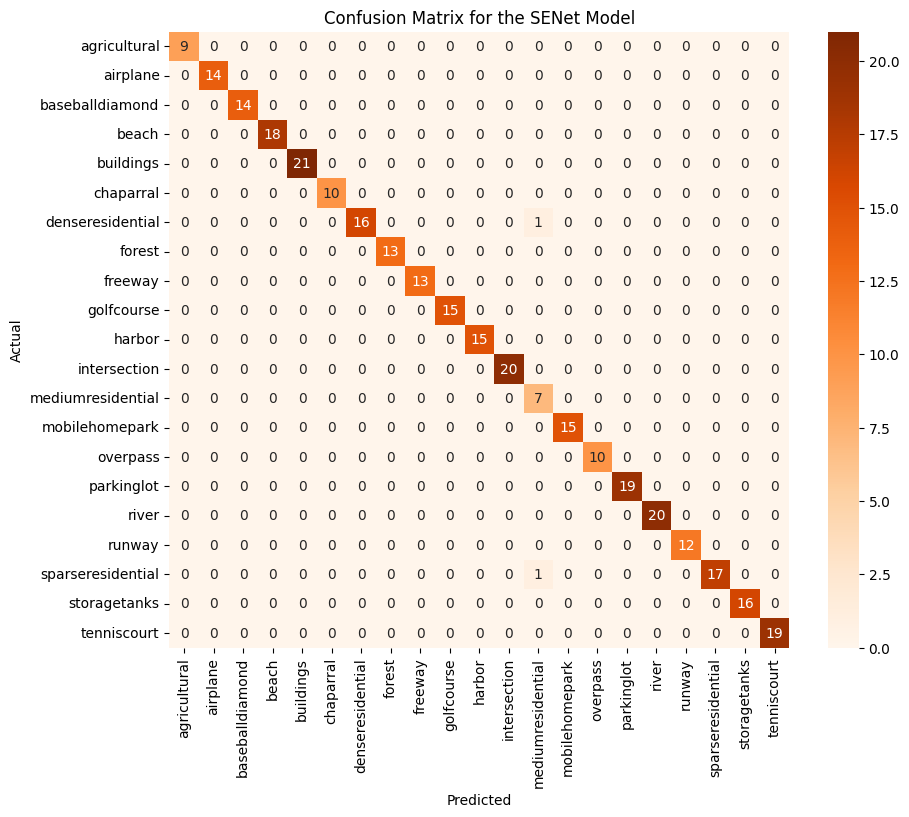

Classification Report:
                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00         9
         airplane       1.00      1.00      1.00        14
  baseballdiamond       1.00      1.00      1.00        14
            beach       1.00      1.00      1.00        18
        buildings       1.00      1.00      1.00        21
        chaparral       1.00      1.00      1.00        10
 denseresidential       1.00      0.94      0.97        17
           forest       1.00      1.00      1.00        13
          freeway       1.00      1.00      1.00        13
       golfcourse       1.00      1.00      1.00        15
           harbor       1.00      1.00      1.00        15
     intersection       1.00      1.00      1.00        20
mediumresidential       0.78      1.00      0.88         7
   mobilehomepark       1.00      1.00      1.00        15
         overpass       1.00      1.00      1.00        10
       parkinglot       1.00    

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model_senet.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_senet(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for the SENet Model')
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))


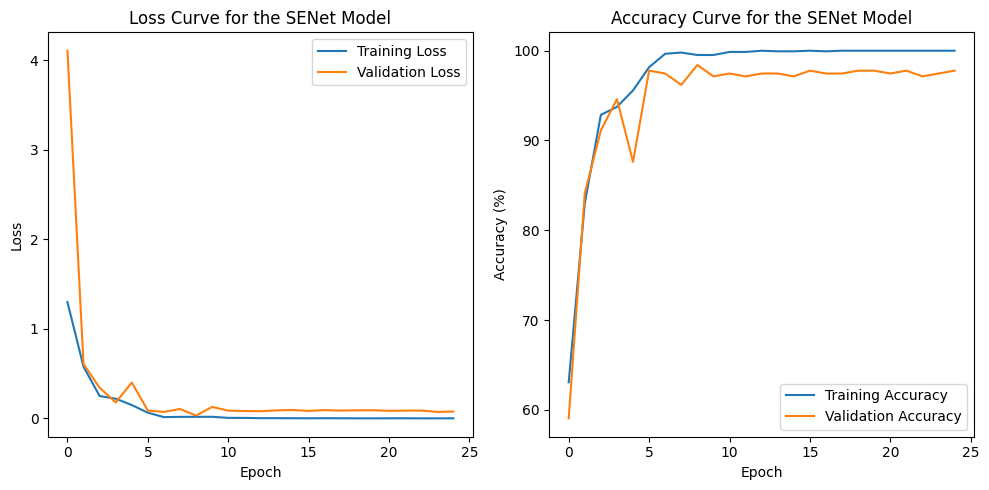

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve for the SENet Model')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curve for the SENet Model')

plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(all_labels, all_preds)
print(f"Kappa Accuracy: {kappa:.4f}")
print(f"Overall Accuracy: {test_accuracy:.4f}")

Kappa Accuracy: 0.9933
Overall Accuracy: 0.9937
